In [14]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset,random_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm
import numpy as np

## Dataset and Dataloader

In [15]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, root_dir, augment=False):
        self.root_dir = root_dir
        self.augment = augment
        self.image_list = []
        self.labels = []
        self.augmented_images = []

        classes = os.listdir(root_dir)
        for class_name in classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                image_names = os.listdir(class_dir)
                tiff_image_names = [img_name for img_name in image_names if img_name.lower().endswith('.tiff') or img_name.lower().endswith('.tif')]
                self.image_list.extend([os.path.join(class_dir, img_name) for img_name in tiff_image_names])
                self.labels.extend([1 if class_name == 'plume' else 0] * len(tiff_image_names))

                if augment:
                    augmented_images = []
                    for img_name in image_names:
                        img_path = os.path.join(class_dir, img_name)
                        image = Image.open(img_path)
                        image = image.resize((64, 64))  # Resize to 64x64

                        # Apply augmentation transformations
                        transform = transforms.Compose([
                            transforms.RandomVerticalFlip(),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor()
                        ])
                        augmented_image = transform(image)
                        augmented_images.append(augmented_image)

                    self.augmented_images.extend(augmented_images)

        if augment:
            self.image_list += self.augmented_images
            self.labels += self.labels * len(self.augmented_images)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image = self.image_list[idx]
        label = self.labels[idx]

        if isinstance(image, str):
            image = Image.open(image)
            image = image.resize((64, 64))  # Resize to 64x64

            transform = transforms.Compose([
                transforms.ToTensor()
            ])
            image = transform(image)

        return image, label

In [23]:
root_dir = "train_val/train"
val_dir = "train_val/validation"

train_dataset = CustomDataset(root_dir, augment=True)
val_dataset = CustomDataset(val_dir, augment=False)


# Define batch size for training and validation
batch_size = 32

# Create the train DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create the validation DataLoader
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Verify the train and validation data loaders
for images, labels in train_loader:
    print(f"Train batch - Images: {images.shape}, Labels: {labels.shape}")
    break

for images, labels in val_loader:
    print(f"Validation batch - Images: {images.shape}, Labels: {labels.shape}")
    break

Train batch - Images: torch.Size([32, 1, 64, 64]), Labels: torch.Size([32])
Validation batch - Images: torch.Size([32, 1, 64, 64]), Labels: torch.Size([32])


## Resnet50

In [11]:
# Define the device for training (CPU or GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet50 model
resnet50 = models.wide_resnet50_2(weights='Wide_ResNet50_2_Weights.IMAGENET1K_V2')

# Modify the first layer to accept single-channel grayscale images
resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the last fully connected layer for binary classification with softmax activation
num_classes = 2  # 2 classes: 1 or 0
resnet50.fc = nn.Sequential(
    nn.Linear(resnet50.fc.in_features, num_classes)
)

In [12]:
# Move the model to the device
resnet50 = resnet50.to(device)

# Define the loss function (criterion)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001)

num_epochs = 40

In [13]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score
best_auc = 0.0
# Training loop
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    resnet50.train()  # Set the model to training mode
    
    epoch_loss = 0.0  # Accumulator for epoch loss
    for images, labels in train_loader:
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        
        # Forward pass
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        epoch_loss += loss.item()
    
    # Compute the average loss for the epoch
    epoch_loss /= len(train_loader)
    tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {epoch_loss}")

    # Validation loop
    resnet50.eval()  # Set the model to evaluation mode

    true_probabilities = []
    predicted_probabilities = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device)

            # Forward pass
            outputs = resnet50(images)
            probabilities = torch.softmax(outputs, dim=1)

            # Collect predicted probabilities and true labels
            predicted_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Assuming binary classification
            true_probabilities.extend(labels.cpu().numpy())

    # Compute the AUC
    auc = roc_auc_score(true_probabilities, predicted_probabilities)
    print(f"Validation AUC: {auc}")
    
    # Check if current accuracy is better than the previous best accuracy
    if auc > best_auc:
        best_auc = auc
        torch.save(resnet50.state_dict(), f"resnet50_{best_auc:.4f}.pth")  # Save the model with AUC in the filename
        print("Saved")
    

Epochs:   0%|                                                                                   | 0/40 [00:02<?, ?it/s]

Epoch 1/40 - Average Loss: 0.5787305757403374
Validation AUC: 0.828551912568306


Epochs:   2%|█▉                                                                         | 1/40 [00:02<01:48,  2.78s/it]

Saved


Epochs:   2%|█▉                                                                         | 1/40 [00:04<01:48,  2.78s/it]

Epoch 2/40 - Average Loss: 0.28013772442936896
Validation AUC: 0.90198087431694


Epochs:   5%|███▊                                                                       | 2/40 [00:05<01:38,  2.58s/it]

Saved


Epochs:   8%|█████▋                                                                     | 3/40 [00:07<01:28,  2.38s/it]

Epoch 3/40 - Average Loss: 0.1250903150998056
Validation AUC: 0.8767076502732241


Epochs:  10%|███████▌                                                                   | 4/40 [00:09<01:22,  2.30s/it]

Epoch 4/40 - Average Loss: 0.0992663905955851
Validation AUC: 0.8831967213114754


Epochs:  12%|█████████▍                                                                 | 5/40 [00:11<01:18,  2.25s/it]

Epoch 5/40 - Average Loss: 0.08321124077774585
Validation AUC: 0.8084016393442623


Epochs:  15%|███████████▎                                                               | 6/40 [00:13<01:15,  2.22s/it]

Epoch 6/40 - Average Loss: 0.13790159225463866
Validation AUC: 0.8697062841530054


Epochs:  15%|███████████▎                                                               | 6/40 [00:15<01:15,  2.22s/it]

Epoch 7/40 - Average Loss: 0.13440130772069098
Validation AUC: 0.9156420765027322


Epochs:  18%|█████████████▏                                                             | 7/40 [00:16<01:15,  2.30s/it]

Saved


Epochs:  20%|███████████████                                                            | 8/40 [00:18<01:12,  2.25s/it]

Epoch 8/40 - Average Loss: 0.06306553832255304
Validation AUC: 0.8835382513661202


Epochs:  22%|████████████████▉                                                          | 9/40 [00:20<01:09,  2.23s/it]

Epoch 9/40 - Average Loss: 0.025845903910521884
Validation AUC: 0.905396174863388


Epochs:  25%|██████████████████▌                                                       | 10/40 [00:22<01:06,  2.21s/it]

Epoch 10/40 - Average Loss: 0.05281592024257407
Validation AUC: 0.8633879781420765


Epochs:  28%|████████████████████▎                                                     | 11/40 [00:24<01:03,  2.19s/it]

Epoch 11/40 - Average Loss: 0.14582735393196344
Validation AUC: 0.8616803278688525


Epochs:  30%|██████████████████████▏                                                   | 12/40 [00:27<01:01,  2.19s/it]

Epoch 12/40 - Average Loss: 0.0824924575863406
Validation AUC: 0.9011270491803278


Epochs:  30%|██████████████████████▏                                                   | 12/40 [00:29<01:01,  2.19s/it]

Epoch 13/40 - Average Loss: 0.08090225947089494
Validation AUC: 0.923155737704918


Epochs:  32%|████████████████████████                                                  | 13/40 [00:29<01:01,  2.27s/it]

Saved


Epochs:  32%|████████████████████████                                                  | 13/40 [00:31<01:01,  2.27s/it]

Epoch 14/40 - Average Loss: 0.058613514568423855
Validation AUC: 0.9330601092896175


Epochs:  35%|█████████████████████████▉                                                | 14/40 [00:32<01:00,  2.33s/it]

Saved


Epochs:  38%|███████████████████████████▊                                              | 15/40 [00:34<00:57,  2.28s/it]

Epoch 15/40 - Average Loss: 0.04621050472487696
Validation AUC: 0.9286202185792349


Epochs:  40%|█████████████████████████████▌                                            | 16/40 [00:36<00:53,  2.25s/it]

Epoch 16/40 - Average Loss: 0.038422490970697255
Validation AUC: 0.9241803278688524


Epochs:  42%|███████████████████████████████▍                                          | 17/40 [00:38<00:51,  2.22s/it]

Epoch 17/40 - Average Loss: 0.12927299486182164
Validation AUC: 0.9129098360655737


Epochs:  45%|█████████████████████████████████▎                                        | 18/40 [00:40<00:48,  2.20s/it]

Epoch 18/40 - Average Loss: 0.12666196338832378
Validation AUC: 0.9323770491803278


Epochs:  48%|███████████████████████████████████▏                                      | 19/40 [00:42<00:46,  2.19s/it]

Epoch 19/40 - Average Loss: 0.08456974965520203
Validation AUC: 0.9293032786885246


Epochs:  50%|█████████████████████████████████████                                     | 20/40 [00:45<00:43,  2.18s/it]

Epoch 20/40 - Average Loss: 0.08038457448128611
Validation AUC: 0.91051912568306


Epochs:  52%|██████████████████████████████████████▊                                   | 21/40 [00:47<00:41,  2.17s/it]

Epoch 21/40 - Average Loss: 0.01666154582053423
Validation AUC: 0.9122267759562842


Epochs:  55%|████████████████████████████████████████▋                                 | 22/40 [00:49<00:39,  2.17s/it]

Epoch 22/40 - Average Loss: 0.017274305767205077
Validation AUC: 0.9043715846994536


Epochs:  57%|██████████████████████████████████████████▌                               | 23/40 [00:51<00:36,  2.17s/it]

Epoch 23/40 - Average Loss: 0.03966298401355743
Validation AUC: 0.9176912568306012


Epochs:  60%|████████████████████████████████████████████▍                             | 24/40 [00:53<00:34,  2.18s/it]

Epoch 24/40 - Average Loss: 0.01707356911501847
Validation AUC: 0.9122267759562842


Epochs:  62%|██████████████████████████████████████████████▎                           | 25/40 [00:55<00:32,  2.17s/it]

Epoch 25/40 - Average Loss: 0.00823339261842193
Validation AUC: 0.9182035519125682


Epochs:  65%|████████████████████████████████████████████████                          | 26/40 [00:58<00:30,  2.18s/it]

Epoch 26/40 - Average Loss: 0.010562544704498578
Validation AUC: 0.917691256830601


Epochs:  68%|█████████████████████████████████████████████████▉                        | 27/40 [01:00<00:28,  2.18s/it]

Epoch 27/40 - Average Loss: 0.04113309113781725
Validation AUC: 0.8982240437158471


Epochs:  70%|███████████████████████████████████████████████████▊                      | 28/40 [01:02<00:26,  2.18s/it]

Epoch 28/40 - Average Loss: 0.06920053004578222
Validation AUC: 0.9012978142076502


Epochs:  72%|█████████████████████████████████████████████████████▋                    | 29/40 [01:04<00:24,  2.19s/it]

Epoch 29/40 - Average Loss: 0.12162979381391778
Validation AUC: 0.8954918032786886


Epochs:  75%|███████████████████████████████████████████████████████▌                  | 30/40 [01:06<00:21,  2.20s/it]

Epoch 30/40 - Average Loss: 0.04413700605509803
Validation AUC: 0.9115437158469946


Epochs:  78%|█████████████████████████████████████████████████████████▎                | 31/40 [01:09<00:19,  2.20s/it]

Epoch 31/40 - Average Loss: 0.017174344324303092
Validation AUC: 0.9135928961748634


Epochs:  80%|███████████████████████████████████████████████████████████▏              | 32/40 [01:11<00:17,  2.20s/it]

Epoch 32/40 - Average Loss: 0.034135619662993125
Validation AUC: 0.9214480874316939


Epochs:  82%|█████████████████████████████████████████████████████████████             | 33/40 [01:13<00:15,  2.19s/it]

Epoch 33/40 - Average Loss: 0.012315668905648636
Validation AUC: 0.9141051912568305


Epochs:  85%|██████████████████████████████████████████████████████████████▉           | 34/40 [01:15<00:13,  2.18s/it]

Epoch 34/40 - Average Loss: 0.014732064047348104
Validation AUC: 0.9187158469945356


Epochs:  88%|████████████████████████████████████████████████████████████████▊         | 35/40 [01:17<00:10,  2.17s/it]

Epoch 35/40 - Average Loss: 0.011292414813033247
Validation AUC: 0.9234972677595629


Epochs:  90%|██████████████████████████████████████████████████████████████████▌       | 36/40 [01:19<00:08,  2.18s/it]

Epoch 36/40 - Average Loss: 0.0063504476129310206
Validation AUC: 0.9166666666666666


Epochs:  92%|████████████████████████████████████████████████████████████████████▍     | 37/40 [01:22<00:06,  2.17s/it]

Epoch 37/40 - Average Loss: 0.012565116794303322
Validation AUC: 0.9064207650273224


Epochs:  95%|██████████████████████████████████████████████████████████████████████▎   | 38/40 [01:24<00:04,  2.17s/it]

Epoch 38/40 - Average Loss: 0.010506757953680789
Validation AUC: 0.915983606557377


Epochs:  98%|████████████████████████████████████████████████████████████████████████▏ | 39/40 [01:26<00:02,  2.17s/it]

Epoch 39/40 - Average Loss: 0.01539554665337164
Validation AUC: 0.91974043715847


Epochs: 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [01:28<00:00,  2.22s/it]

Epoch 40/40 - Average Loss: 0.00597173698079132
Validation AUC: 0.9217896174863387


## Resnet101

In [8]:
# Define the device for training (CPU or GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet101 model
resnet101 = models.resnet101(weights='ResNet101_Weights.DEFAULT')

# Modify the first layer to accept single-channel grayscale images
resnet101.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the last fully connected layer for binary classification with softmax activation
num_classes = 2  # 2 classes: 1 or 0
resnet101.fc = nn.Sequential(
    nn.Linear(resnet101.fc.in_features, num_classes)
)

In [9]:
# Move the model to the device
resnet101 = resnet101.to(device)

# Define the loss function (criterion)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(resnet101.parameters(), lr=0.001)

num_epochs = 40

In [10]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score
best_auc = 0.0
# Training loop
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    resnet101.train()  # Set the model to training mode
    
    epoch_loss = 0.0  # Accumulator for epoch loss
    for images, labels in train_loader:
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        
        # Forward pass
        outputs = resnet101(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        epoch_loss += loss.item()
    
    # Compute the average loss for the epoch
    epoch_loss /= len(train_loader)
    tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {epoch_loss}")

    # Validation loop
    resnet101.eval()  # Set the model to evaluation mode

    true_probabilities = []
    predicted_probabilities = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device)

            # Forward pass
            outputs = resnet101(images)
            probabilities = torch.softmax(outputs, dim=1)

            # Collect predicted probabilities and true labels
            predicted_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Assuming binary classification
            true_probabilities.extend(labels.cpu().numpy())

    # Compute the AUC
    auc = roc_auc_score(true_probabilities, predicted_probabilities)
    print(f"Validation AUC: {auc}")
    
    # Check if current accuracy is better than the previous best accuracy
    if auc > best_auc:
        best_auc = auc
        torch.save(resnet101.state_dict(), f"resnet101_{best_auc:.4f}.pth")  # Save the model with AUC in the filename
        print("Saved")
    

Epochs:   0%|                                                                                   | 0/40 [00:03<?, ?it/s]

Epoch 1/40 - Average Loss: 0.5523270070552826
Validation AUC: 0.7253994953742641


Epochs:   2%|█▉                                                                         | 1/40 [00:03<02:15,  3.48s/it]

Saved


Epochs:   2%|█▉                                                                         | 1/40 [00:06<02:15,  3.48s/it]

Epoch 2/40 - Average Loss: 0.2706263784319162


Epochs:   5%|███▊                                                                       | 2/40 [00:06<02:06,  3.34s/it]

Validation AUC: 0.7228763666947015


Epochs:   5%|███▊                                                                       | 2/40 [00:09<02:06,  3.34s/it]

Epoch 3/40 - Average Loss: 0.20702776201069356


Epochs:   8%|█████▋                                                                     | 3/40 [00:09<02:00,  3.25s/it]

Validation AUC: 0.7186711522287637


Epochs:   8%|█████▋                                                                     | 3/40 [00:12<02:00,  3.25s/it]

Epoch 4/40 - Average Loss: 0.1834823599085212
Validation AUC: 0.8216989066442388


Epochs:  10%|███████▌                                                                   | 4/40 [00:13<01:55,  3.21s/it]

Saved


Epochs:  12%|█████████▍                                                                 | 5/40 [00:16<01:50,  3.15s/it]

Epoch 5/40 - Average Loss: 0.07309574214741588
Validation AUC: 0.796888141295206


Epochs:  12%|█████████▍                                                                 | 5/40 [00:18<01:50,  3.15s/it]

Epoch 6/40 - Average Loss: 0.044536938238888976
Validation AUC: 0.751892346509672


Epochs:  15%|███████████▎                                                               | 6/40 [00:21<01:45,  3.10s/it]

Epoch 7/40 - Average Loss: 0.04342429502867162
Validation AUC: 0.8465096719932717


Epochs:  18%|█████████████▏                                                             | 7/40 [00:22<01:44,  3.16s/it]

Saved


Epochs:  20%|███████████████                                                            | 8/40 [00:25<01:41,  3.18s/it]

Epoch 8/40 - Average Loss: 0.05828734738752246
Validation AUC: 0.7771236333052987


Epochs:  22%|████████████████▉                                                          | 9/40 [00:28<01:37,  3.15s/it]

Epoch 9/40 - Average Loss: 0.059220426809042694
Validation AUC: 0.7783851976450799


Epochs:  25%|██████████████████▌                                                       | 10/40 [00:31<01:34,  3.14s/it]

Epoch 10/40 - Average Loss: 0.1396665668929927
Validation AUC: 0.6843986543313709


Epochs:  28%|████████████████████▎                                                     | 11/40 [00:34<01:28,  3.07s/it]

Epoch 11/40 - Average Loss: 0.17337757535278797
Validation AUC: 0.7636669470142977


Epochs:  30%|██████████████████████▏                                                   | 12/40 [00:37<01:25,  3.04s/it]

Epoch 12/40 - Average Loss: 0.10244550034403802
Validation AUC: 0.7754415475189235


Epochs:  32%|████████████████████████                                                  | 13/40 [00:40<01:22,  3.05s/it]

Epoch 13/40 - Average Loss: 0.12263240367174148
Validation AUC: 0.802775441547519


Epochs:  35%|█████████████████████████▉                                                | 14/40 [00:43<01:20,  3.09s/it]

Epoch 14/40 - Average Loss: 0.12623733012005686
Validation AUC: 0.689655172413793


Epochs:  38%|███████████████████████████▊                                              | 15/40 [00:46<01:16,  3.06s/it]

Epoch 15/40 - Average Loss: 0.0376849245512858
Validation AUC: 0.7954163162321278


Epochs:  38%|███████████████████████████▊                                              | 15/40 [00:49<01:16,  3.06s/it]

Epoch 16/40 - Average Loss: 0.06687839741352945


Epochs:  40%|█████████████████████████████▌                                            | 16/40 [00:50<01:13,  3.08s/it]

Validation AUC: 0.7674516400336416


Epochs:  40%|█████████████████████████████▌                                            | 16/40 [00:52<01:13,  3.08s/it]

Epoch 17/40 - Average Loss: 0.08576808744110168


Epochs:  42%|███████████████████████████████▍                                          | 17/40 [00:53<01:10,  3.09s/it]

Validation AUC: 0.8280067283431455


Epochs:  45%|█████████████████████████████████▎                                        | 18/40 [00:56<01:08,  3.12s/it]

Epoch 18/40 - Average Loss: 0.01599008858356683
Validation AUC: 0.8052985702270816


Epochs:  48%|███████████████████████████████████▏                                      | 19/40 [00:59<01:05,  3.10s/it]

Epoch 19/40 - Average Loss: 0.009573297189490404
Validation AUC: 0.7947855340622372


Epochs:  50%|█████████████████████████████████████                                     | 20/40 [01:02<01:02,  3.12s/it]

Epoch 20/40 - Average Loss: 0.04521025060657848
Validation AUC: 0.6976450798990748


Epochs:  52%|██████████████████████████████████████▊                                   | 21/40 [01:05<00:59,  3.11s/it]

Epoch 21/40 - Average Loss: 0.039187199145089835
Validation AUC: 0.8027754415475189


Epochs:  55%|████████████████████████████████████████▋                                 | 22/40 [01:08<00:55,  3.10s/it]

Epoch 22/40 - Average Loss: 0.036194888246245685
Validation AUC: 0.8162321278385197


Epochs:  57%|██████████████████████████████████████████▌                               | 23/40 [01:11<00:52,  3.08s/it]

Epoch 23/40 - Average Loss: 0.08760885982774198
Validation AUC: 0.7750210260723297


Epochs:  60%|████████████████████████████████████████████▍                             | 24/40 [01:14<00:49,  3.09s/it]

Epoch 24/40 - Average Loss: 0.027204557844379453
Validation AUC: 0.7655592935239697


Epochs:  60%|████████████████████████████████████████████▍                             | 24/40 [01:17<00:49,  3.09s/it]

Epoch 25/40 - Average Loss: 0.024025235952285583


Epochs:  62%|██████████████████████████████████████████████▎                           | 25/40 [01:17<00:46,  3.07s/it]

Validation AUC: 0.7905803195962994


Epochs:  65%|████████████████████████████████████████████████                          | 26/40 [01:21<00:43,  3.09s/it]

Epoch 26/40 - Average Loss: 0.031207010442449244
Validation AUC: 0.6909167367535743


Epochs:  65%|████████████████████████████████████████████████                          | 26/40 [01:23<00:43,  3.09s/it]

Epoch 27/40 - Average Loss: 0.01760429588321131


Epochs:  68%|█████████████████████████████████████████████████▉                        | 27/40 [01:24<00:40,  3.11s/it]

Validation AUC: 0.75946173254836


Epochs:  70%|███████████████████████████████████████████████████▊                      | 28/40 [01:27<00:37,  3.13s/it]

Epoch 28/40 - Average Loss: 0.013522298297903034
Validation AUC: 0.7685029436501262


Epochs:  72%|█████████████████████████████████████████████████████▋                    | 29/40 [01:30<00:34,  3.15s/it]

Epoch 29/40 - Average Loss: 0.006498128458770225
Validation AUC: 0.7584104289318755


Epochs:  75%|███████████████████████████████████████████████████████▌                  | 30/40 [01:33<00:31,  3.13s/it]

Epoch 30/40 - Average Loss: 0.004766667442981998
Validation AUC: 0.7455845248107653


Epochs:  78%|█████████████████████████████████████████████████████████▎                | 31/40 [01:36<00:28,  3.13s/it]

Epoch 31/40 - Average Loss: 0.0045402398810438175
Validation AUC: 0.7472666105971404


Epochs:  78%|█████████████████████████████████████████████████████████▎                | 31/40 [01:39<00:28,  3.13s/it]

Epoch 32/40 - Average Loss: 0.004557356079976671


Epochs:  80%|███████████████████████████████████████████████████████████▏              | 32/40 [01:39<00:24,  3.11s/it]

Validation AUC: 0.7491589571068125


Epochs:  80%|███████████████████████████████████████████████████████████▏              | 32/40 [01:42<00:24,  3.11s/it]

Epoch 33/40 - Average Loss: 0.005011979792561761


Epochs:  82%|█████████████████████████████████████████████████████████████             | 33/40 [01:42<00:21,  3.07s/it]

Validation AUC: 0.7527333894028595


Epochs:  85%|██████████████████████████████████████████████████████████████▉           | 34/40 [01:45<00:18,  3.07s/it]

Epoch 34/40 - Average Loss: 0.004743843967344219
Validation AUC: 0.7523128679562658


Epochs:  88%|████████████████████████████████████████████████████████████████▊         | 35/40 [01:49<00:15,  3.09s/it]

Epoch 35/40 - Average Loss: 0.004281208277916448
Validation AUC: 0.7512615643397814


Epochs:  90%|██████████████████████████████████████████████████████████████████▌       | 36/40 [01:52<00:12,  3.12s/it]

Epoch 36/40 - Average Loss: 0.005620931055227629
Validation AUC: 0.7577796467619848


Epochs:  92%|████████████████████████████████████████████████████████████████████▍     | 37/40 [01:55<00:09,  3.13s/it]

Epoch 37/40 - Average Loss: 0.004429563104929457
Validation AUC: 0.7565180824222035


Epochs:  95%|██████████████████████████████████████████████████████████████████████▎   | 38/40 [01:58<00:06,  3.12s/it]

Epoch 38/40 - Average Loss: 0.004528781477893063
Validation AUC: 0.7529436501261564


Epochs:  98%|████████████████████████████████████████████████████████████████████████▏ | 39/40 [02:01<00:03,  3.12s/it]

Epoch 39/40 - Average Loss: 0.004464343424569961
Validation AUC: 0.7502102607232969


Epochs: 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [02:04<00:00,  3.12s/it]

Epoch 40/40 - Average Loss: 0.004889156664103211
Validation AUC: 0.75336417157275


Epochs: 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [02:04<00:00,  3.12s/it]


## Resnet152

In [11]:
# Define the device for training (CPU or GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet101 model
resnet152 = models.resnet152(weights='ResNet152_Weights.DEFAULT')

# Modify the first layer to accept single-channel grayscale images
resnet152.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the last fully connected layer for binary classification with softmax activation
num_classes = 2  # 2 classes: 1 or 0
resnet152.fc = nn.Sequential(
    nn.Linear(resnet152.fc.in_features, num_classes)
)

In [12]:
# Move the model to the device
resnet152 = resnet152.to(device)

# Define the loss function (criterion)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(resnet152.parameters(), lr=0.001)

num_epochs = 40

In [13]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score
best_auc = 0.0
# Training loop
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    resnet152.train()  # Set the model to training mode
    
    epoch_loss = 0.0  # Accumulator for epoch loss
    for images, labels in train_loader:
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        
        # Forward pass
        outputs = resnet152(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        epoch_loss += loss.item()
    
    # Compute the average loss for the epoch
    epoch_loss /= len(train_loader)
    tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {epoch_loss}")

    # Validation loop
    resnet152.eval()  # Set the model to evaluation mode

    true_probabilities = []
    predicted_probabilities = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device)

            # Forward pass
            outputs = resnet152(images)
            probabilities = torch.softmax(outputs, dim=1)

            # Collect predicted probabilities and true labels
            predicted_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Assuming binary classification
            true_probabilities.extend(labels.cpu().numpy())

    # Compute the AUC
    auc = roc_auc_score(true_probabilities, predicted_probabilities)
    print(f"Validation AUC: {auc}")
    
    # Check if current accuracy is better than the previous best accuracy
    if auc > best_auc:
        best_auc = auc
        torch.save(resnet152.state_dict(), f"resnet152_{best_auc:.4f}.pth")  # Save the model with AUC in the filename
        print("Saved")
    

Epochs:   0%|                                                                                   | 0/40 [00:04<?, ?it/s]

Epoch 1/40 - Average Loss: 0.554765410721302
Validation AUC: 0.8322119428090833


Epochs:   2%|█▉                                                                         | 1/40 [00:04<03:13,  4.97s/it]

Saved


Epochs:   2%|█▉                                                                         | 1/40 [00:08<03:13,  4.97s/it]

Epoch 2/40 - Average Loss: 0.38640792220830916


Epochs:   5%|███▊                                                                       | 2/40 [00:09<02:52,  4.53s/it]

Validation AUC: 0.8183347350714887


Epochs:   5%|███▊                                                                       | 2/40 [00:13<02:52,  4.53s/it]

Epoch 3/40 - Average Loss: 0.2298201858997345
Validation AUC: 0.843986543313709


Epochs:   8%|█████▋                                                                     | 3/40 [00:13<02:49,  4.58s/it]

Saved


Epochs:   8%|█████▋                                                                     | 3/40 [00:17<02:49,  4.58s/it]

Epoch 4/40 - Average Loss: 0.17310999939218163


Epochs:  10%|███████▌                                                                   | 4/40 [00:18<02:40,  4.46s/it]

Validation AUC: 0.8036164844407064


Epochs:  10%|███████▌                                                                   | 4/40 [00:22<02:40,  4.46s/it]

Epoch 5/40 - Average Loss: 0.14540989762172102


Epochs:  12%|█████████▍                                                                 | 5/40 [00:22<02:34,  4.42s/it]

Validation AUC: 0.7985702270815812


Epochs:  12%|█████████▍                                                                 | 5/40 [00:26<02:34,  4.42s/it]

Epoch 6/40 - Average Loss: 0.09704861831851304


Epochs:  15%|███████████▎                                                               | 6/40 [00:26<02:27,  4.34s/it]

Validation AUC: 0.8107653490328007


Epochs:  15%|███████████▎                                                               | 6/40 [00:30<02:27,  4.34s/it]

Epoch 7/40 - Average Loss: 0.14081177450716495


Epochs:  18%|█████████████▏                                                             | 7/40 [00:30<02:23,  4.35s/it]

Validation AUC: 0.7905803195962994


Epochs:  18%|█████████████▏                                                             | 7/40 [00:35<02:23,  4.35s/it]

Epoch 8/40 - Average Loss: 0.0777827606187202


Epochs:  20%|███████████████                                                            | 8/40 [00:35<02:19,  4.37s/it]

Validation AUC: 0.7691337258200169


Epochs:  20%|███████████████                                                            | 8/40 [00:39<02:19,  4.37s/it]

Epoch 9/40 - Average Loss: 0.07569502533879131


Epochs:  22%|████████████████▉                                                          | 9/40 [00:39<02:15,  4.38s/it]

Validation AUC: 0.7510513036164845


Epochs:  22%|████████████████▉                                                          | 9/40 [00:43<02:15,  4.38s/it]

Epoch 10/40 - Average Loss: 0.10108553831232711


Epochs:  25%|██████████████████▌                                                       | 10/40 [00:44<02:09,  4.33s/it]

Validation AUC: 0.7582001682085787


Epochs:  25%|██████████████████▌                                                       | 10/40 [00:48<02:09,  4.33s/it]

Epoch 11/40 - Average Loss: 0.0767774699255824
Validation AUC: 0.9083263246425568


Epochs:  28%|████████████████████▎                                                     | 11/40 [00:48<02:08,  4.42s/it]

Saved


Epochs:  28%|████████████████████▎                                                     | 11/40 [00:52<02:08,  4.42s/it]

Epoch 12/40 - Average Loss: 0.07366225021251012


Epochs:  30%|██████████████████████▏                                                   | 12/40 [00:52<02:02,  4.36s/it]

Validation AUC: 0.8021446593776282


Epochs:  30%|██████████████████████▏                                                   | 12/40 [00:56<02:02,  4.36s/it]

Epoch 13/40 - Average Loss: 0.05186026762239635


Epochs:  32%|████████████████████████                                                  | 13/40 [00:57<01:57,  4.34s/it]

Validation AUC: 0.8830950378469302


Epochs:  32%|████████████████████████                                                  | 13/40 [01:01<01:57,  4.34s/it]

Epoch 14/40 - Average Loss: 0.00964964997365314


Epochs:  35%|█████████████████████████▉                                                | 14/40 [01:01<01:52,  4.32s/it]

Validation AUC: 0.8753153910849454


Epochs:  35%|█████████████████████████▉                                                | 14/40 [01:05<01:52,  4.32s/it]

Epoch 15/40 - Average Loss: 0.037316644046950384


Epochs:  38%|███████████████████████████▊                                              | 15/40 [01:05<01:47,  4.30s/it]

Validation AUC: 0.8166526492851136


Epochs:  38%|███████████████████████████▊                                              | 15/40 [01:09<01:47,  4.30s/it]

Epoch 16/40 - Average Loss: 0.009191213780650288


Epochs:  40%|█████████████████████████████▌                                            | 16/40 [01:09<01:42,  4.28s/it]

Validation AUC: 0.8309503784693019


Epochs:  40%|█████████████████████████████▌                                            | 16/40 [01:13<01:42,  4.28s/it]

Epoch 17/40 - Average Loss: 0.032910164725035426


Epochs:  42%|███████████████████████████████▍                                          | 17/40 [01:14<01:38,  4.29s/it]

Validation AUC: 0.8284272497897393


Epochs:  42%|███████████████████████████████▍                                          | 17/40 [01:18<01:38,  4.29s/it]

Epoch 18/40 - Average Loss: 0.0604193399194628


Epochs:  45%|█████████████████████████████████▎                                        | 18/40 [01:18<01:33,  4.27s/it]

Validation AUC: 0.8940285954583684


Epochs:  45%|█████████████████████████████████▎                                        | 18/40 [01:22<01:33,  4.27s/it]

Epoch 19/40 - Average Loss: 0.03353976102152956


Epochs:  48%|███████████████████████████████████▏                                      | 19/40 [01:22<01:30,  4.33s/it]

Validation AUC: 0.8183347350714887


Epochs:  48%|███████████████████████████████████▏                                      | 19/40 [01:27<01:30,  4.33s/it]

Epoch 20/40 - Average Loss: 0.040444342097907794


Epochs:  50%|█████████████████████████████████████                                     | 20/40 [01:27<01:26,  4.35s/it]

Validation AUC: 0.8578637510513036


Epochs:  50%|█████████████████████████████████████                                     | 20/40 [01:31<01:26,  4.35s/it]

Epoch 21/40 - Average Loss: 0.044160327765712284


Epochs:  52%|██████████████████████████████████████▊                                   | 21/40 [01:31<01:23,  4.42s/it]

Validation AUC: 0.8187552565180823


Epochs:  52%|██████████████████████████████████████▊                                   | 21/40 [01:36<01:23,  4.42s/it]

Epoch 22/40 - Average Loss: 0.09695232855156063


Epochs:  55%|████████████████████████████████████████▋                                 | 22/40 [01:36<01:19,  4.42s/it]

Validation AUC: 0.780067283431455


Epochs:  55%|████████████████████████████████████████▋                                 | 22/40 [01:40<01:19,  4.42s/it]

Epoch 23/40 - Average Loss: 0.09719116021879018


Epochs:  57%|██████████████████████████████████████████▌                               | 23/40 [01:40<01:14,  4.41s/it]

Validation AUC: 0.7432716568544996


Epochs:  57%|██████████████████████████████████████████▌                               | 23/40 [01:44<01:14,  4.41s/it]

Epoch 24/40 - Average Loss: 0.10383163406513632


Epochs:  60%|████████████████████████████████████████████▍                             | 24/40 [01:45<01:09,  4.37s/it]

Validation AUC: 0.787426408746846


Epochs:  60%|████████████████████████████████████████████▍                             | 24/40 [01:49<01:09,  4.37s/it]

Epoch 25/40 - Average Loss: 0.06098293827380985


Epochs:  62%|██████████████████████████████████████████████▎                           | 25/40 [01:49<01:06,  4.41s/it]

Validation AUC: 0.8553406223717409


Epochs:  62%|██████████████████████████████████████████████▎                           | 25/40 [01:53<01:06,  4.41s/it]

Epoch 26/40 - Average Loss: 0.018572510291414802


Epochs:  65%|████████████████████████████████████████████████                          | 26/40 [01:53<01:00,  4.33s/it]

Validation AUC: 0.843986543313709


Epochs:  65%|████████████████████████████████████████████████                          | 26/40 [01:57<01:00,  4.33s/it]

Epoch 27/40 - Average Loss: 0.03360407873697113


Epochs:  68%|█████████████████████████████████████████████████▉                        | 27/40 [01:57<00:56,  4.31s/it]

Validation AUC: 0.7962573591253154


Epochs:  68%|█████████████████████████████████████████████████▉                        | 27/40 [02:01<00:56,  4.31s/it]

Epoch 28/40 - Average Loss: 0.018237656613564468


Epochs:  70%|███████████████████████████████████████████████████▊                      | 28/40 [02:02<00:51,  4.31s/it]

Validation AUC: 0.8071909167367537


Epochs:  70%|███████████████████████████████████████████████████▊                      | 28/40 [02:06<00:51,  4.31s/it]

Epoch 29/40 - Average Loss: 0.04527431239985162


Epochs:  72%|█████████████████████████████████████████████████████▋                    | 29/40 [02:06<00:47,  4.29s/it]

Validation AUC: 0.7430613961312027


Epochs:  72%|█████████████████████████████████████████████████████▋                    | 29/40 [02:10<00:47,  4.29s/it]

Epoch 30/40 - Average Loss: 0.07419322360656225


Epochs:  75%|███████████████████████████████████████████████████████▌                  | 30/40 [02:10<00:42,  4.28s/it]

Validation AUC: 0.7779646761984861


Epochs:  75%|███████████████████████████████████████████████████████▌                  | 30/40 [02:14<00:42,  4.28s/it]

Epoch 31/40 - Average Loss: 0.05558447993826121


Epochs:  78%|█████████████████████████████████████████████████████████▎                | 31/40 [02:15<00:38,  4.29s/it]

Validation AUC: 0.8393608074011775


Epochs:  78%|█████████████████████████████████████████████████████████▎                | 31/40 [02:19<00:38,  4.29s/it]

Epoch 32/40 - Average Loss: 0.08502704347483814


Epochs:  80%|███████████████████████████████████████████████████████████▏              | 32/40 [02:19<00:34,  4.32s/it]

Validation AUC: 0.8042472666105972


Epochs:  80%|███████████████████████████████████████████████████████████▏              | 32/40 [02:23<00:34,  4.32s/it]

Epoch 33/40 - Average Loss: 0.029763377178460358


Epochs:  82%|█████████████████████████████████████████████████████████████             | 33/40 [02:24<00:30,  4.43s/it]

Validation AUC: 0.7926829268292682


Epochs:  82%|█████████████████████████████████████████████████████████████             | 33/40 [02:28<00:30,  4.43s/it]

Epoch 34/40 - Average Loss: 0.008351227236562408


Epochs:  85%|██████████████████████████████████████████████████████████████▉           | 34/40 [02:28<00:26,  4.43s/it]

Validation AUC: 0.7975189234650968


Epochs:  85%|██████████████████████████████████████████████████████████████▉           | 34/40 [02:32<00:26,  4.43s/it]

Epoch 35/40 - Average Loss: 0.013214728766797634


Epochs:  88%|████████████████████████████████████████████████████████████████▊         | 35/40 [02:32<00:22,  4.41s/it]

Validation AUC: 0.8023549201009252


Epochs:  88%|████████████████████████████████████████████████████████████████▊         | 35/40 [02:37<00:22,  4.41s/it]

Epoch 36/40 - Average Loss: 0.10395537912845612


Epochs:  90%|██████████████████████████████████████████████████████████████████▌       | 36/40 [02:37<00:17,  4.40s/it]

Validation AUC: 0.836417157275021


Epochs:  90%|██████████████████████████████████████████████████████████████████▌       | 36/40 [02:41<00:17,  4.40s/it]

Epoch 37/40 - Average Loss: 0.1338735199533403


Epochs:  92%|████████████████████████████████████████████████████████████████████▍     | 37/40 [02:41<00:13,  4.39s/it]

Validation AUC: 0.8099243061396131


Epochs:  92%|████████████████████████████████████████████████████████████████████▍     | 37/40 [02:45<00:13,  4.39s/it]

Epoch 38/40 - Average Loss: 0.1132605554535985


Epochs:  95%|██████████████████████████████████████████████████████████████████████▎   | 38/40 [02:46<00:08,  4.39s/it]

Validation AUC: 0.8309503784693019


Epochs:  95%|██████████████████████████████████████████████████████████████████████▎   | 38/40 [02:50<00:08,  4.39s/it]

Epoch 39/40 - Average Loss: 0.021825791470473633


Epochs:  98%|████████████████████████████████████████████████████████████████████████▏ | 39/40 [02:50<00:04,  4.38s/it]

Validation AUC: 0.8385197645079899


Epochs:  98%|████████████████████████████████████████████████████████████████████████▏ | 39/40 [02:54<00:04,  4.38s/it]

Epoch 40/40 - Average Loss: 0.009464032989490079


Epochs: 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [02:54<00:00,  4.37s/it]

Validation AUC: 0.8444070647603028


## EfficientNet

In [14]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet
from tqdm import tqdm

# Define the device for training (CPU or GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained EfficientNet model
efficientnet_model = efficientnet.efficientnet_b7(weights='EfficientNet_B7_Weights.IMAGENET1K_V1')

# Modify the input layer to accept single-channel grayscale images
efficientnet_model.features[0][0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

# Modify the classifier head for binary classification
num_classes = 2  # 2 classes: 1 or 0
in_features = efficientnet_model.classifier[1].in_features
dropout_rate = efficientnet_model.classifier[0].p

# Remove the existing layers in the classifier head
efficientnet_model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_rate),
    nn.Linear(in_features, num_classes)
)


In [15]:
# Move the model to the device
efficientnet_model = efficientnet_model.to(device)

# Define the loss function (criterion)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(efficientnet_model.parameters(), lr=0.001)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=8, factor=0.1, verbose=True)

num_epochs = 40

In [16]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score
best_auc = 0.0
# Training loop
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    efficientnet_model.train()  # Set the model to training mode
    
    epoch_loss = 0.0  # Accumulator for epoch loss
    for images, labels in train_loader:
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        
        # Forward pass
        outputs = efficientnet_model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        epoch_loss += loss.item()
    
    # Compute the average loss for the epoch
    epoch_loss /= len(train_loader)
    tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {epoch_loss}")

    # Validation loop
    efficientnet_model.eval()  # Set the model to evaluation mode

    true_probabilities = []
    predicted_probabilities = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device)

            # Forward pass
            outputs = efficientnet_model(images)
            probabilities = torch.softmax(outputs, dim=1)

            # Collect predicted probabilities and true labels
            predicted_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Assuming binary classification
            true_probabilities.extend(labels.cpu().numpy())

    # Compute the AUC
    auc = roc_auc_score(true_probabilities, predicted_probabilities)
    print(f"Validation AUC: {auc}")
    
    # Check if current accuracy is better than the previous best accuracy
    if auc > best_auc:
        best_auc = auc
        torch.save(efficientnet_model.state_dict(), f"efficientnet_model_{best_auc:.4f}.pth")  # Save the model with AUC in the filename
        print("Saved")
    

Epochs:   0%|                                                                                   | 0/40 [00:05<?, ?it/s]

Epoch 1/40 - Average Loss: 0.5987944766879082
Validation AUC: 0.684188393608074


Epochs:   2%|█▉                                                                         | 1/40 [00:06<04:14,  6.54s/it]

Saved


Epochs:   2%|█▉                                                                         | 1/40 [00:12<04:14,  6.54s/it]

Epoch 2/40 - Average Loss: 0.28962987288832664
Validation AUC: 0.796888141295206


Epochs:   5%|███▊                                                                       | 2/40 [00:12<04:00,  6.32s/it]

Saved


Epochs:   5%|███▊                                                                       | 2/40 [00:18<04:00,  6.32s/it]

Epoch 3/40 - Average Loss: 0.1929044622927904
Validation AUC: 0.8212783851976451


Epochs:   8%|█████▋                                                                     | 3/40 [00:18<03:52,  6.29s/it]

Saved


Epochs:   8%|█████▋                                                                     | 3/40 [00:24<03:52,  6.29s/it]

Epoch 4/40 - Average Loss: 0.15339869018644095


Epochs:  10%|███████▌                                                                   | 4/40 [00:24<03:41,  6.14s/it]

Validation AUC: 0.7207737594617325


Epochs:  10%|███████▌                                                                   | 4/40 [00:30<03:41,  6.14s/it]

Epoch 5/40 - Average Loss: 0.10245733025949448


Epochs:  12%|█████████▍                                                                 | 5/40 [00:30<03:30,  6.00s/it]

Validation AUC: 0.7863751051303617


Epochs:  12%|█████████▍                                                                 | 5/40 [00:36<03:30,  6.00s/it]

Epoch 6/40 - Average Loss: 0.10498551826458424
Validation AUC: 0.8376787216148023


Epochs:  15%|███████████▎                                                               | 6/40 [00:36<03:25,  6.04s/it]

Saved


Epochs:  15%|███████████▎                                                               | 6/40 [00:42<03:25,  6.04s/it]

Epoch 7/40 - Average Loss: 0.11252230927348136


Epochs:  18%|█████████████▏                                                             | 7/40 [00:42<03:18,  6.01s/it]

Validation AUC: 0.8208578637510514


Epochs:  18%|█████████████▏                                                             | 7/40 [00:48<03:18,  6.01s/it]

Epoch 8/40 - Average Loss: 0.05836394114885479
Validation AUC: 0.8500841042893188


Epochs:  20%|███████████████                                                            | 8/40 [00:48<03:15,  6.10s/it]

Saved


Epochs:  20%|███████████████                                                            | 8/40 [00:54<03:15,  6.10s/it]

Epoch 9/40 - Average Loss: 0.09335240161162801


Epochs:  22%|████████████████▉                                                          | 9/40 [00:54<03:07,  6.04s/it]

Validation AUC: 0.7394869638351556


Epochs:  22%|████████████████▉                                                          | 9/40 [01:00<03:07,  6.04s/it]

Epoch 10/40 - Average Loss: 0.10759822237305343


Epochs:  25%|██████████████████▌                                                       | 10/40 [01:00<02:59,  5.98s/it]

Validation AUC: 0.8084524810765349


Epochs:  25%|██████████████████▌                                                       | 10/40 [01:06<02:59,  5.98s/it]

Epoch 11/40 - Average Loss: 0.0362092519091675


Epochs:  28%|████████████████████▎                                                     | 11/40 [01:06<02:51,  5.92s/it]

Validation AUC: 0.8389402859545836


Epochs:  28%|████████████████████▎                                                     | 11/40 [01:12<02:51,  5.92s/it]

Epoch 12/40 - Average Loss: 0.013635331869591028


Epochs:  30%|██████████████████████▏                                                   | 12/40 [01:12<02:45,  5.91s/it]

Validation AUC: 0.823380992430614


Epochs:  30%|██████████████████████▏                                                   | 12/40 [01:18<02:45,  5.91s/it]

Epoch 13/40 - Average Loss: 0.017647766198206228


Epochs:  32%|████████████████████████                                                  | 13/40 [01:18<02:39,  5.91s/it]

Validation AUC: 0.8313708999158957


Epochs:  32%|████████████████████████                                                  | 13/40 [01:23<02:39,  5.91s/it]

Epoch 14/40 - Average Loss: 0.05803591691947076
Validation AUC: 0.8793103448275862


Epochs:  35%|█████████████████████████▉                                                | 14/40 [01:24<02:36,  6.02s/it]

Saved


Epochs:  35%|█████████████████████████▉                                                | 14/40 [01:30<02:36,  6.02s/it]

Epoch 15/40 - Average Loss: 0.03252929308218881


Epochs:  38%|███████████████████████████▊                                              | 15/40 [01:30<02:28,  5.96s/it]

Validation AUC: 0.8200168208578638


Epochs:  38%|███████████████████████████▊                                              | 15/40 [01:35<02:28,  5.96s/it]

Epoch 16/40 - Average Loss: 0.04289521698374301


Epochs:  40%|█████████████████████████████▌                                            | 16/40 [01:36<02:21,  5.88s/it]

Validation AUC: 0.823380992430614


Epochs:  40%|█████████████████████████████▌                                            | 16/40 [01:41<02:21,  5.88s/it]

Epoch 17/40 - Average Loss: 0.02650214724126272


Epochs:  42%|███████████████████████████████▍                                          | 17/40 [01:41<02:15,  5.88s/it]

Validation AUC: 0.8675357443229604


Epochs:  42%|███████████████████████████████▍                                          | 17/40 [01:47<02:15,  5.88s/it]

Epoch 18/40 - Average Loss: 0.08053588315087837


Epochs:  45%|█████████████████████████████████▎                                        | 18/40 [01:47<02:09,  5.88s/it]

Validation AUC: 0.8166526492851136


Epochs:  45%|█████████████████████████████████▎                                        | 18/40 [01:53<02:09,  5.88s/it]

Epoch 19/40 - Average Loss: 0.05887399462517351


Epochs:  48%|███████████████████████████████████▏                                      | 19/40 [01:53<02:03,  5.88s/it]

Validation AUC: 0.8481917577796467


Epochs:  48%|███████████████████████████████████▏                                      | 19/40 [01:59<02:03,  5.88s/it]

Epoch 20/40 - Average Loss: 0.07275184859245201


Epochs:  50%|█████████████████████████████████████                                     | 20/40 [01:59<01:57,  5.87s/it]

Validation AUC: 0.8040370058873002


Epochs:  50%|█████████████████████████████████████                                     | 20/40 [02:05<01:57,  5.87s/it]

Epoch 21/40 - Average Loss: 0.05640638275654055


Epochs:  52%|██████████████████████████████████████▊                                   | 21/40 [02:05<01:51,  5.85s/it]

Validation AUC: 0.8460891505466779


Epochs:  52%|██████████████████████████████████████▊                                   | 21/40 [02:11<01:51,  5.85s/it]

Epoch 22/40 - Average Loss: 0.020796001009875907


Epochs:  55%|████████████████████████████████████████▋                                 | 22/40 [02:11<01:46,  5.90s/it]

Validation AUC: 0.7754415475189235


Epochs:  55%|████████████████████████████████████████▋                                 | 22/40 [02:17<01:46,  5.90s/it]

Epoch 23/40 - Average Loss: 0.008656043162045535


Epochs:  57%|██████████████████████████████████████████▌                               | 23/40 [02:17<01:40,  5.94s/it]

Validation AUC: 0.8042472666105971


Epochs:  57%|██████████████████████████████████████████▌                               | 23/40 [02:23<01:40,  5.94s/it]

Epoch 24/40 - Average Loss: 0.006491817228379659


Epochs:  60%|████████████████████████████████████████████▍                             | 24/40 [02:23<01:34,  5.92s/it]

Validation AUC: 0.8090832632464257


Epochs:  60%|████████████████████████████████████████████▍                             | 24/40 [02:28<01:34,  5.92s/it]

Epoch 25/40 - Average Loss: 0.013774765506605035


Epochs:  62%|██████████████████████████████████████████████▎                           | 25/40 [02:29<01:28,  5.93s/it]

Validation AUC: 0.7985702270815811


Epochs:  62%|██████████████████████████████████████████████▎                           | 25/40 [02:34<01:28,  5.93s/it]

Epoch 26/40 - Average Loss: 0.021294385927467373


Epochs:  65%|████████████████████████████████████████████████                          | 26/40 [02:35<01:23,  5.94s/it]

Validation AUC: 0.7825904121110177


Epochs:  65%|████████████████████████████████████████████████                          | 26/40 [02:40<01:23,  5.94s/it]

Epoch 27/40 - Average Loss: 0.007445803775044624


Epochs:  68%|█████████████████████████████████████████████████▉                        | 27/40 [02:41<01:17,  5.99s/it]

Validation AUC: 0.7880571909167366


Epochs:  68%|█████████████████████████████████████████████████▉                        | 27/40 [02:47<01:17,  5.99s/it]

Epoch 28/40 - Average Loss: 0.005422021138656419


Epochs:  70%|███████████████████████████████████████████████████▊                      | 28/40 [02:47<01:12,  6.05s/it]

Validation AUC: 0.7981497056349874


Epochs:  70%|███████████████████████████████████████████████████▊                      | 28/40 [02:53<01:12,  6.05s/it]

Epoch 29/40 - Average Loss: 0.005154013694482274


Epochs:  72%|█████████████████████████████████████████████████████▋                    | 29/40 [02:53<01:06,  6.06s/it]

Validation AUC: 0.8069806560134567


Epochs:  72%|█████████████████████████████████████████████████████▋                    | 29/40 [02:59<01:06,  6.06s/it]

Epoch 30/40 - Average Loss: 0.019421656449230794


Epochs:  75%|███████████████████████████████████████████████████████▌                  | 30/40 [02:59<01:00,  6.10s/it]

Validation AUC: 0.8162321278385197


Epochs:  75%|███████████████████████████████████████████████████████▌                  | 30/40 [03:05<01:00,  6.10s/it]

Epoch 31/40 - Average Loss: 0.04680950591573492


Epochs:  78%|█████████████████████████████████████████████████████████▎                | 31/40 [03:05<00:54,  6.07s/it]

Validation AUC: 0.8355761143818334


Epochs:  78%|█████████████████████████████████████████████████████████▎                | 31/40 [03:11<00:54,  6.07s/it]

Epoch 32/40 - Average Loss: 0.04017311140196398


Epochs:  80%|███████████████████████████████████████████████████████████▏              | 32/40 [03:11<00:48,  6.02s/it]

Validation AUC: 0.8389402859545837


Epochs:  80%|███████████████████████████████████████████████████████████▏              | 32/40 [03:17<00:48,  6.02s/it]

Epoch 33/40 - Average Loss: 0.03282411686668638


Epochs:  82%|█████████████████████████████████████████████████████████████             | 33/40 [03:17<00:42,  6.01s/it]

Validation AUC: 0.8355761143818334


Epochs:  82%|█████████████████████████████████████████████████████████████             | 33/40 [03:23<00:42,  6.01s/it]

Epoch 34/40 - Average Loss: 0.0143682379683014


Epochs:  85%|██████████████████████████████████████████████████████████████▉           | 34/40 [03:23<00:36,  6.01s/it]

Validation AUC: 0.8019343986543314


Epochs:  85%|██████████████████████████████████████████████████████████████▉           | 34/40 [03:29<00:36,  6.01s/it]

Epoch 35/40 - Average Loss: 0.007640172060200711


Epochs:  88%|████████████████████████████████████████████████████████████████▊         | 35/40 [03:29<00:30,  6.04s/it]

Validation AUC: 0.8460891505466779


Epochs:  88%|████████████████████████████████████████████████████████████████▊         | 35/40 [03:35<00:30,  6.04s/it]

Epoch 36/40 - Average Loss: 0.005834515195601853


Epochs:  90%|██████████████████████████████████████████████████████████████████▌       | 36/40 [03:35<00:24,  6.05s/it]

Validation AUC: 0.8536585365853658


Epochs:  90%|██████████████████████████████████████████████████████████████████▌       | 36/40 [03:41<00:24,  6.05s/it]

Epoch 37/40 - Average Loss: 0.004357820227596676


Epochs:  92%|████████████████████████████████████████████████████████████████████▍     | 37/40 [03:41<00:18,  6.06s/it]

Validation AUC: 0.8498738435660219


Epochs:  92%|████████████████████████████████████████████████████████████████████▍     | 37/40 [03:47<00:18,  6.06s/it]

Epoch 38/40 - Average Loss: 0.006047587388275133


Epochs:  95%|██████████████████████████████████████████████████████████████████████▎   | 38/40 [03:47<00:12,  6.04s/it]

Validation AUC: 0.8435660218671153


Epochs:  95%|██████████████████████████████████████████████████████████████████████▎   | 38/40 [03:53<00:12,  6.04s/it]

Epoch 39/40 - Average Loss: 0.008714107965533912


Epochs:  98%|████████████████████████████████████████████████████████████████████████▏ | 39/40 [03:53<00:05,  5.96s/it]

Validation AUC: 0.8393608074011775


Epochs:  98%|████████████████████████████████████████████████████████████████████████▏ | 39/40 [03:59<00:05,  5.96s/it]

Epoch 40/40 - Average Loss: 0.01289551539994136


Epochs: 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [03:59<00:00,  5.99s/it]

Validation AUC: 0.8368376787216147


## Check

### Resnet50

In [17]:
# Define the device for training (CPU or GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet50 model
resnet50 = models.wide_resnet50_2(weights='Wide_ResNet50_2_Weights.IMAGENET1K_V2')

# Modify the first layer to accept single-channel grayscale images
resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the last fully connected layer for binary classification with softmax activation
num_classes = 2  # 2 classes: 1 or 0
resnet50.fc = nn.Sequential(
    nn.Linear(resnet50.fc.in_features, num_classes)
)
resnet50.load_state_dict(torch.load('resnet50_0.9268.pth'))
resnet50.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

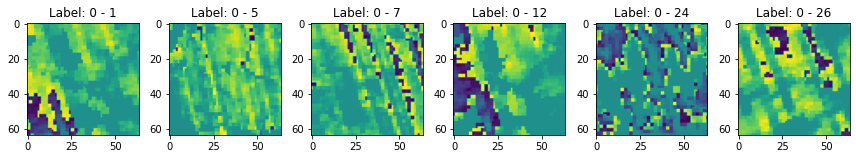

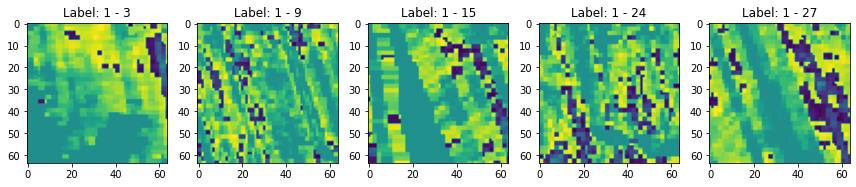

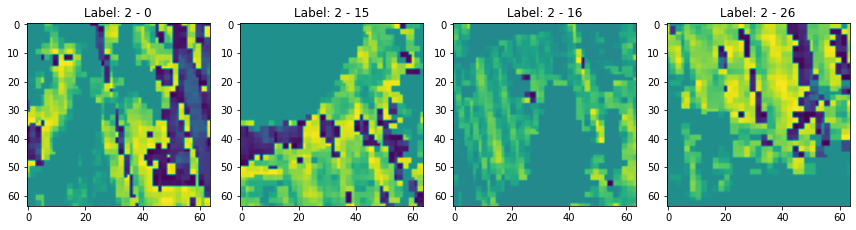

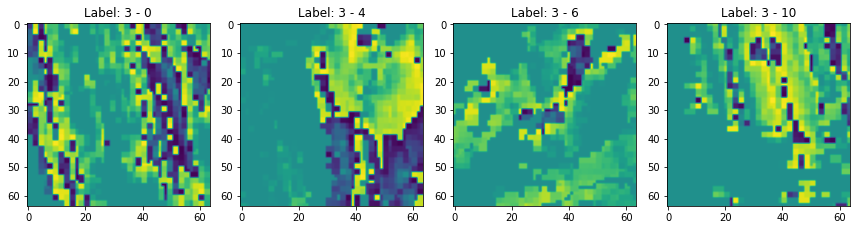

In [18]:
resnet50.eval()

for batch_num, batch in enumerate(val_loader):
    images, labels = batch
    images = images.to(device, dtype=torch.float)
    labels = labels.to(device)
    
    # Forward pass
    outputs = resnet50(images)
    _, predicted = torch.max(outputs.data, 1)
    
    index = predicted == labels
    index = [i  for i, x in enumerate(list(index.cpu().numpy())) if x == False]
    
    # Create a grid of subplots to display the images
    fig, axes = plt.subplots(1, len(index), figsize=(12, 5))
    for i, idx in enumerate(index):
        image = images[idx]
        # Convert the tensor to a numpy array and reshape it
        image = image.cpu().squeeze().numpy()

        # Display the image
        axes[i].imshow(image, cmap='viridis')
        axes[i].set_title(f"Label: {batch_num} - {idx}")

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    

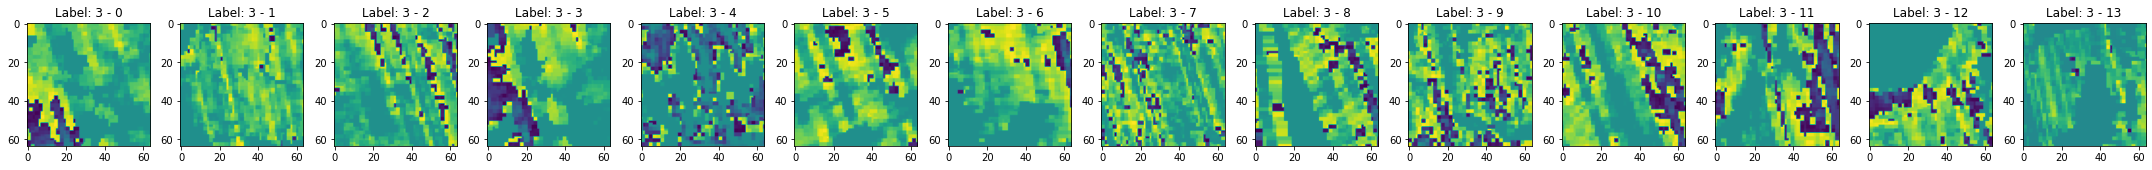

In [21]:
resnet50.eval()

misclassified_images = []  # List to store misclassified images

for batch_num, batch in enumerate(val_loader):
    images, labels = batch
    images = images.to(device, dtype=torch.float)
    labels = labels.to(device)

    # Forward pass
    outputs = resnet50(images)
    _, predicted = torch.max(outputs.data, 1)

    index = (predicted != labels) & (labels == 0)  # Filter misclassified images with true class equal to 1
    misclassified_indices = [i for i, x in enumerate(index.cpu().numpy()) if x]

    # Add misclassified images to the list 
    for idx in misclassified_indices:
        misclassified_images.append(images[idx].cpu().numpy())

# Display the misclassified images
fig, axes = plt.subplots(1, len(misclassified_images), figsize=(30, 10))
for i, image in enumerate(misclassified_images):
    axes[i].imshow(image.squeeze(), cmap='viridis')
    axes[i].set_title(f"Label: {batch_num} - {i}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [22]:
true_probabilities = []
predicted_probabilities = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)

        # Forward pass
        outputs = resnet50(images)
        probabilities = torch.softmax(outputs, dim=1)

        # Collect predicted probabilities and true labels
        predicted_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Assuming binary classification
        true_probabilities.extend(labels.cpu().numpy())

# Compute the AUC
auc = roc_auc_score(true_probabilities, predicted_probabilities)
print(f"Validation AUC: {auc}")

Validation AUC: 0.9268292682926829


## Resnet101

In [7]:
# Define the device for training (CPU or GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet101 model
resnet101 = models.resnet101(weights='ResNet101_Weights.DEFAULT')

# Modify the first layer to accept single-channel grayscale images
resnet101.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the last fully connected layer for binary classification with softmax activation
num_classes = 2  # 2 classes: 1 or 0
resnet101.fc = nn.Sequential(
    nn.Linear(resnet101.fc.in_features, num_classes)
)

resnet101.load_state_dict(torch.load('weight/cut_2/resnet101_0.8468468468468469.pth'))
resnet101.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

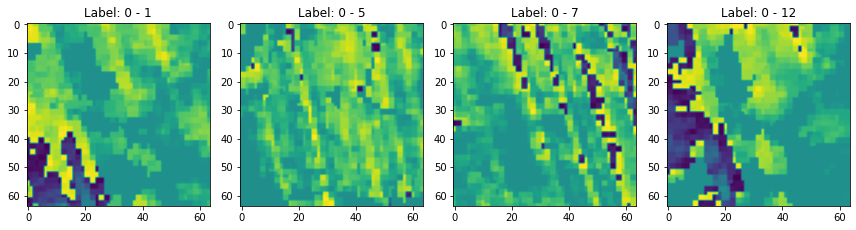

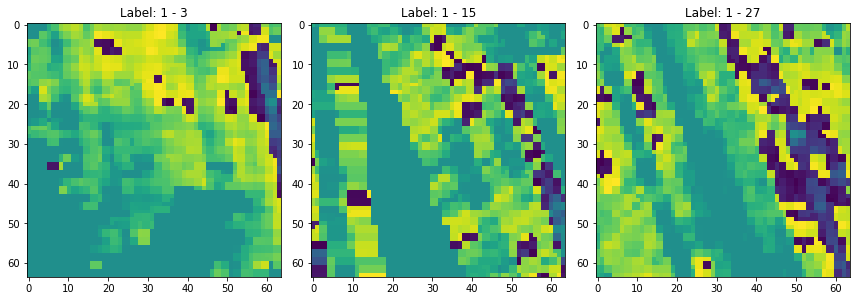

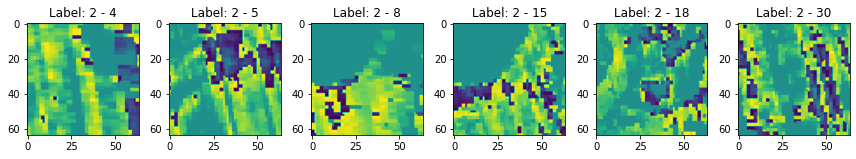

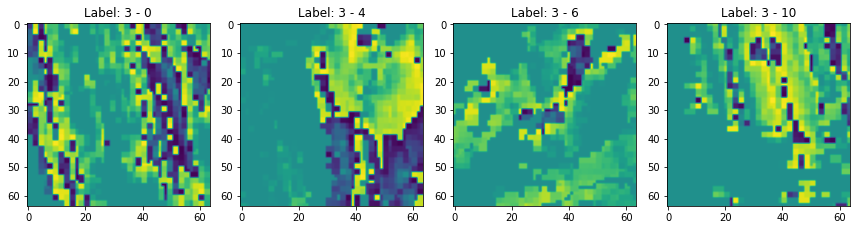

In [10]:
resnet101.eval()

for batch_num, batch in enumerate(val_loader):
    images, labels = batch
    images = images.to(device, dtype=torch.float)
    labels = labels.to(device)
    
    # Forward pass
    outputs = resnet101(images)
    _, predicted = torch.max(outputs.data, 1)
    
    index = predicted == labels
    index = [i  for i, x in enumerate(list(index.cpu().numpy())) if x == False]
    
    # Create a grid of subplots to display the images
    fig, axes = plt.subplots(1, len(index), figsize=(12, 5))
    for i, idx in enumerate(index):
        image = images[idx]
        # Convert the tensor to a numpy array and reshape it
        image = image.cpu().squeeze().numpy()

        # Display the image
        axes[i].imshow(image, cmap='viridis')
        axes[i].set_title(f"Label: {batch_num} - {idx}")

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    

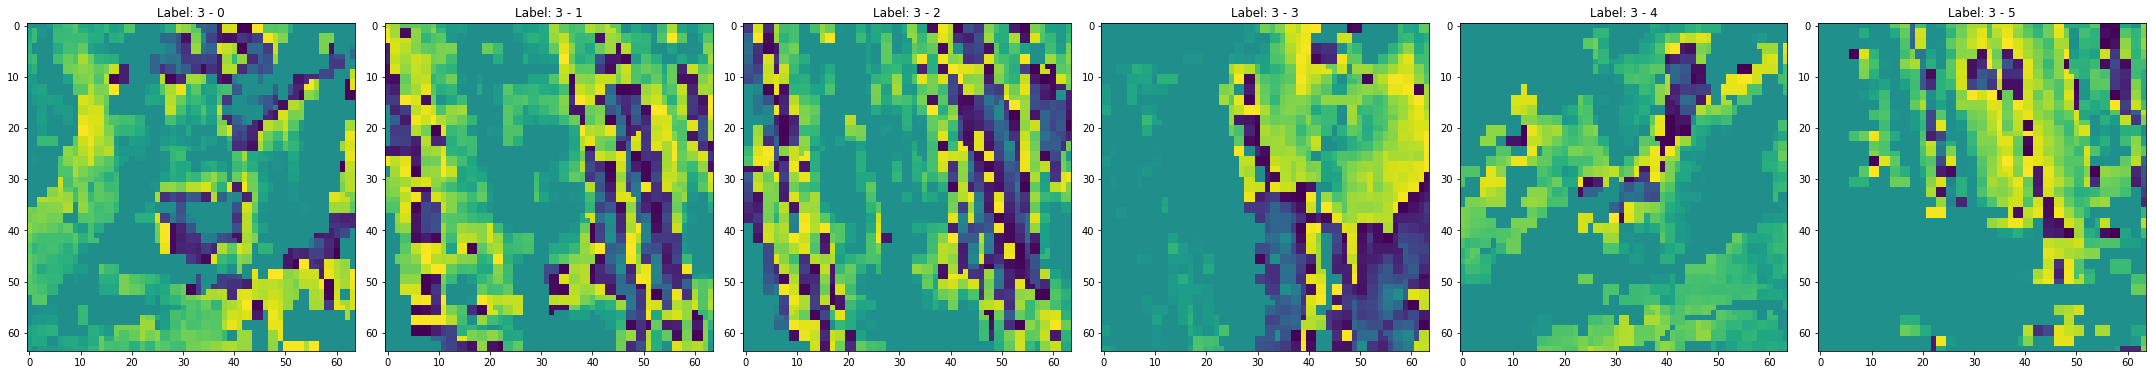

In [15]:
resnet101.eval()

misclassified_images = []  # List to store misclassified images

for batch_num, batch in enumerate(val_loader):
    images, labels = batch
    images = images.to(device, dtype=torch.float)
    labels = labels.to(device)

    # Forward pass
    outputs = resnet101(images)
    _, predicted = torch.max(outputs.data, 1)

    index = (predicted != labels) & (labels == 1)  # Filter misclassified images with true class equal to 1
    misclassified_indices = [i for i, x in enumerate(index.cpu().numpy()) if x]

    # Add misclassified images to the list 
    for idx in misclassified_indices:
        misclassified_images.append(images[idx].cpu().numpy())

# Display the misclassified images
fig, axes = plt.subplots(1, len(misclassified_images), figsize=(30, 10))
for i, image in enumerate(misclassified_images):
    axes[i].imshow(image.squeeze(), cmap='viridis')
    axes[i].set_title(f"Label: {batch_num} - {i}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


### EfficientNet

In [27]:
# Load the pre-trained EfficientNet model
efficientnet_model = efficientnet.efficientnet_b7(weights='EfficientNet_B7_Weights.IMAGENET1K_V1')

# Modify the input layer to accept single-channel grayscale images
efficientnet_model.features[0][0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

# Modify the classifier head for binary classification
num_classes = 2  # 2 classes: 1 or 0
in_features = efficientnet_model.classifier[1].in_features
dropout_rate = efficientnet_model.classifier[0].p

# Remove the existing layers in the classifier head
efficientnet_model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_rate),
    nn.Linear(in_features, num_classes)
)


efficientnet_model.load_state_dict(torch.load('EfficientNet_0.8372093023255814.pth'))
efficientnet_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

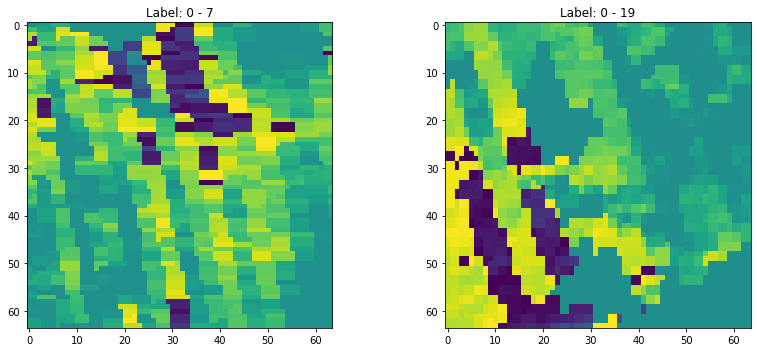

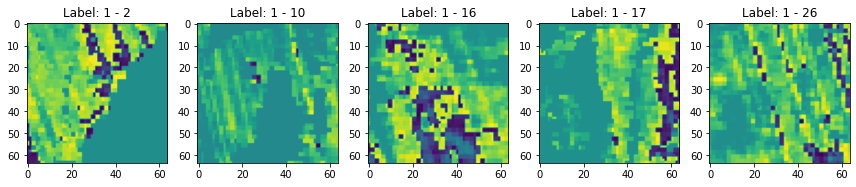

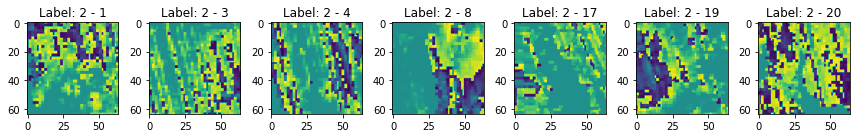

In [33]:
efficientnet_model.eval()

for batch_num, batch in enumerate(val_loader):
    images, labels = batch
    images = images.to(device, dtype=torch.float)
    labels = labels.to(device)
    
    # Forward pass
    outputs = efficientnet_model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    index = predicted == labels
    index = [i  for i, x in enumerate(list(index.cpu().numpy())) if x == False]
    
    # Create a grid of subplots to display the images
    fig, axes = plt.subplots(1, len(index), figsize=(12, 5))
    for i, idx in enumerate(index):
        image = images[idx]
        # Convert the tensor to a numpy array and reshape it
        image = image.cpu().squeeze().numpy()

        # Display the image
        axes[i].imshow(image, cmap='viridis')
        axes[i].set_title(f"Label: {batch_num} - {idx}")

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    

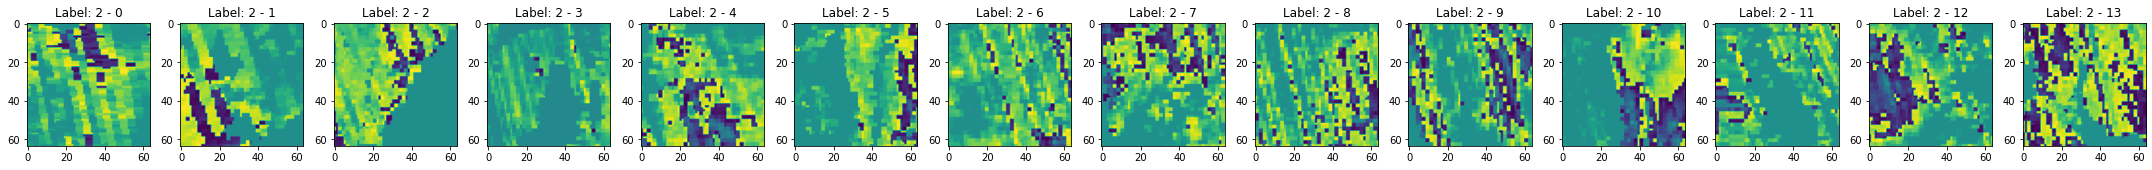

In [40]:
efficientnet_model.eval()

misclassified_images = []  # List to store misclassified images

for batch_num, batch in enumerate(val_loader):
    images, labels = batch
    images = images.to(device, dtype=torch.float)
    labels = labels.to(device)

    # Forward pass
    outputs = efficientnet_model(images)
    _, predicted = torch.max(outputs.data, 1)

    index = (predicted != labels)  # Filter misclassified images with true class equal to 1
    misclassified_indices = [i for i, x in enumerate(index.cpu().numpy()) if x]

    # Add misclassified images to the list
    for idx in misclassified_indices:
        misclassified_images.append(images[idx].cpu().numpy())

# Display the misclassified images
fig, axes = plt.subplots(1, len(misclassified_images), figsize=(30, 10))
for i, image in enumerate(misclassified_images):
    axes[i].imshow(image.squeeze(), cmap='viridis')
    axes[i].set_title(f"Label: {batch_num} - {i}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
